# 画像修復

## 目的
このチュートリアルでは
* 古い写真上の小さなノイズや引っかき傷などを画像修復(inpainting)と呼ばれる技術によって消す方法を学ぶ．
* OpenCVの修復のための関数の使い方を学ぶ．

## 基礎
折れ目や傷がついてしまった古い写真を持っている人は多いだろう．そのような写真を修復しようと考えたことはあるだろうか?写真の傷をペイントツールを使って簡単に消したりはできない．ペイントツールでは単に黒い部分を白い部分で置き換えるだけだからである。このような画像の修復には「画像修復(image inpainting)」と呼ばれる技術が使われる．基本のアイデアは単純である: 傷を周囲の画素で置換え、周囲の画素に似せるのである．下の画像([Wikipedia](http://en.wikipedia.org/wiki/Inpainting) から引用)について考えてみよう:

![Inpainting example](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/inpaint_basics.jpg)

この目的のためにいくつかのアルゴリズムが設計されているが、OpenCVにはそのうちの２つを提供している．どちらのアルゴリズムも [cv2.inpaint(src, inpaintMask, inpaintRadius, flag)](http://docs.opencv.org/3.0-beta/modules/photo/doc/inpainting.html?highlight=cv2.inpaint#cv2.inpaint) 関数によって使える．

その一つ目はAlexandru Teleaによる2004年の論文 “***An Image Inpainting Technique Based on the Fast Marching Method***”で提案されたアルゴリズムである．このアルゴリズムはFast Marching Methodを基にしたアルゴリズムである．上の画像で傷がついた領域を修復することを考えてみよう．まずこの領域の境界から内側に向かって徐々に値を埋めていく(傷を修復する)．それには、まず修復対象の近傍領域の画素の小さな近傍を考える。そしてこの画素を，その周囲の画素で既知の(つまり傷がついていない)画素すべての正規化された重み付き和によって置換する．この時，重みをどのように決めるかが重要である．修復対象の画素に近い画素や境界線の法線に近い画素，境界の輪郭上の画素に対し、より大きな重みを与える．ひとつの画素を修復したら，Fast Marching Method(FMM)を用いて次の最近傍点に修復対象を移動する．FMMにより、画素値が既知の画素(傷がついていない，もしくは修復済みの画素)に近い画素から順番に修復していくことが保証され，手作業で行うヒューリスティックな手法のように機能する．このアルゴリズムを使うときは第4引数flagに対し cv2.INPAINT_TELEA を指定する．

２つ目のアルゴリズムはBertalmio, Marcelo, Andrea L. Bertozzi &amp; Guillermo Sapiroが2001年に発表した論文 “***Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting***” で提案された手法である．このアルゴリズムは流体力学に基づくアルゴリズムで偏微分方程式を利用している．その基本はヒューリスティックスである．まず初めに画素値が既知の領域から未知の領域へエッジに沿って探索を行う(エッジは連続的なものであるから)．このエッジは等しい輝度値の画素を繋ぐ等輝度線を構成し、修復領域の境界線の法線ベクトルに相当する．これを実現するために流体力学の手法が使われている．これが作られたら次に，その等輝度線に囲まれる領域内の輝度の分散が最小となるような色で埋める．このアルゴリズムを使うには第４引数flagに対し cv2.INPAINT_NS を指定する．



## コード(実装)
画像修復を行うには，入力画像と同じサイズのマスク画像を作成する必要がある．このマスク画像ではゼロでない値の画素が修復すべき画素を表す．それ以外は簡単である．私が故意にペイントツールで追加した黒い線の除去を行ってみよう．あらかじめペイントツールで下に示すような引っかき傷のような絵を作っておいた ([使用した画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_photo/py_inpainting/messi_2.jpg), [マスク](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_photo/py_inpainting/mask2.png))

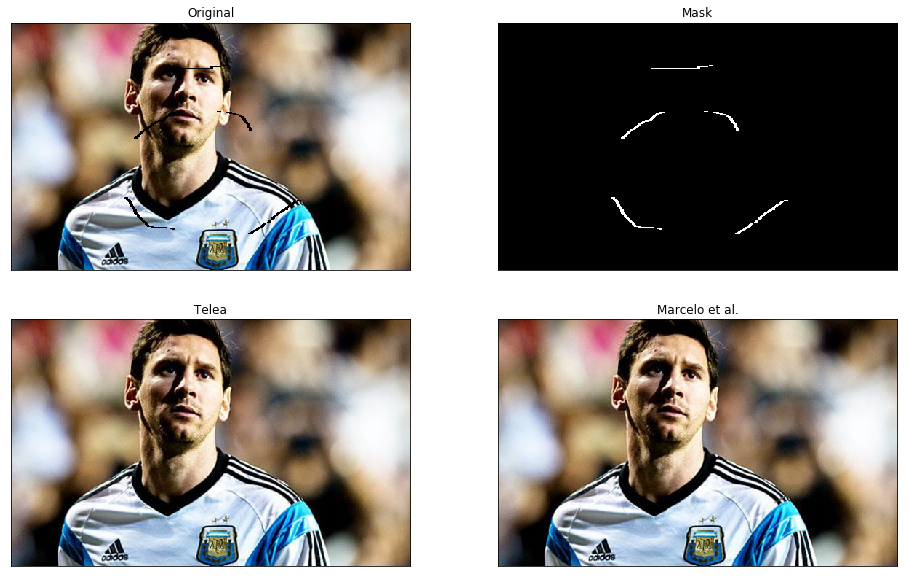

In [5]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('messi_2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
mask = cv2.imread('mask2.png',0)

# making noised image
mask1 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
img = cv2.bitwise_and(img,mask1)

# making mask
mask = cv2.bitwise_not(mask)

dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
dst2 = cv2.inpaint(img,mask,3,cv2.INPAINT_NS)

plt.figure(figsize=(16,10))
plt.subplot(2,2,1),plt.imshow(img)
plt.xticks([]),plt.yticks([]),plt.title('Original')
plt.subplot(2,2,2),plt.imshow(mask,cmap='gray')
plt.xticks([]),plt.yticks([]),plt.title('Mask')
plt.subplot(2,2,3),plt.imshow(dst)
plt.xticks([]),plt.yticks([]),plt.title('Telea')
plt.subplot(2,2,4),plt.imshow(dst2)
plt.xticks([]),plt.yticks([]),plt.title('Marcelo et al.')

plt.show()

左上の画像が入力劣化画像，右上の画像がマスク画像，左下の画像が第一のアルゴリズムによる修復画像，右下の画像が第二のアルゴリズムによる修復画像である

## 補足資料
1. Bertalmio, Marcelo, Andrea L. Bertozzi, & Guillermo Sapiro. “[Navier-stokes, fluid dynamics, and image and video inpainting](http://www.math.ucla.edu/~bertozzi/papers/cvpr01.pdf)”. In Computer Vision and Pattern Recognition, 2001. CVPR 2001. Proceedings of the 2001 IEEE Computer Society Conference on, vol. 1, pp. I-355. IEEE, 2001.
2. Telea, Alexandru. “[An image inpainting technique based on the fast marching method](https://pdfs.semanticscholar.org/622d/5f432e515da69f8f220fb92b17c8426d0427.pdf)". Journal of graphics tools 9.1 (2004): 23-34.

## 課題
1. OpenCVのサンプルに対話的な画像修復のサンプル [samples/python2/inpaint.py](https://raw.githubusercontent.com/npinto/opencv/master/samples/python2/inpaint.py) がある．試してみよう．(注意: これはPython2であり、かつ[common.py](https://github.com/opencv/opencv/raw/master/samples/python/common.py)が必要)
2. [Content-Aware Fill](http://www.youtube.com/watch?v=ZtoUiplKa2A) というAdobe Photoshopのinpaintingの機能の動画がある．GIMPにも同様の機能である “Resynthesizer” がある．試しに使ってみると楽しめるだろう．